## MO444 Project 3 - Reinforcement Learning

* Rodrigo Araújo Marinho Franco - RA: 233569
* Felipe Marinho Tavares - RA: 265680

### Contributions:
* Rodrigo
 * ...
* Felipe
 * ...

# PART I - Evolutionary Model

# PART II - Reinforcement Learning

In [1]:
import sys
sys.path.append("search/")

import torch
import matplotlib.pyplot as plt

import environment

## SmallClassic Environment - Training

Initial state:


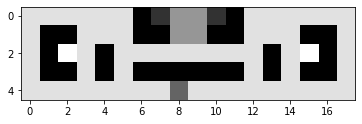

Shape:  (5, 18, 1)
Episode:  100 Average Score: -35.94 Winrate: 0.00% New best score! 
Episode:  200 Average Score: -17.76 Winrate: 0.00% New best score! 
Episode:  300 Average Score: 6.89 Winrate: 0.00% New best score! 
Episode:  400 Average Score: 13.34 Winrate: 0.00% New best score! 
Episode:  500 Average Score: 45.71 Winrate: 0.00% New best score! 
Episode:  600 Average Score: 53.55 Winrate: 0.00% New best score! 
Episode:  700 Average Score: 74.77 Winrate: 0.00% New best score! 
Episode:  800 Average Score: 135.55 Winrate: 7.00% New best score! 
Episode:  900 Average Score: 90.17 Winrate: 1.00% Patience: 1
Episode:  1000 Average Score: 133.59 Winrate: 5.00% Patience: 2
Episode:  1100 Average Score: 162.90 Winrate: 10.00% New best score! 
Episode:  1200 Average Score: 232.07 Winrate: 14.00% New best score! 
Episode:  1300 Average Score: 225.53 Winrate: 13.00% Patience: 1
Episode:  1400 Average Score: 221.90 Winrate: 11.00% Patience: 2
Episode:  1500 Average Score: 229.41 Winrate: 1

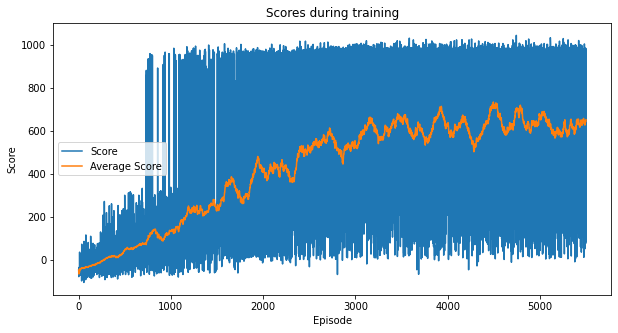

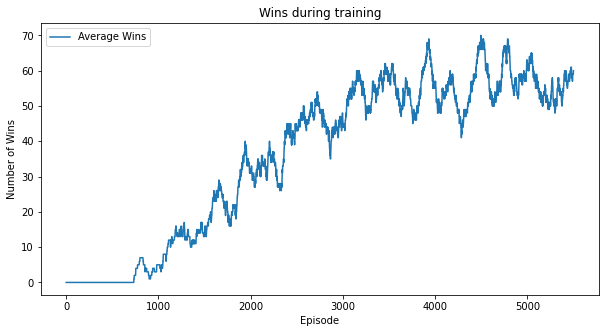

In [2]:
params = {
    "buffer_size": int(1e5),  # replay buffer size
    "batch_size": 32,        # minibatch size
    "gamma": 0.99,            # discount factor
    "tau": 1e-3,              # for soft update of target parameters
    "lr": 1e-3,               # learning rate
    "weight_decay": 0.0001,   # Adam parameter
    "update_every": 10         # how often to update the network
}

# layouts = smallClassic, mediumClassic, originalClassic
env = environment.Environment(params, layout="smallClassic", use_features=True)

eps_start = 1.0   # Starting exploration rate
eps_end = 0.05    # Minimun exploration rate (0.05 = 5%)
eps_decay=0.999
n_episodes = 10000
print_every = 100 # episodes
patience = 10      # max print_every without improvement tolarated
checkpoints_without_improvement = 0

eps = eps_start
best_score = -1000
for i_episode in range(1, n_episodes + 1):
    env.reset()

    while not env.done():
        env.step(eps)

    eps = max(eps_end, eps_decay*eps)

    env.scores.append(env.game.state.getScore())
    env.scores_window.append(env.game.state.getScore())

    env.wins.append(env.game.state.isWin())
    env.wins_window.append(env.game.state.isWin())

    average_score = sum(env.scores_window)/float(len(env.scores_window))
    winrate = sum(env.wins_window)/float(len(env.wins_window)) * 100.0
    env.average_scores.append(average_score)
    env.average_wins.append(winrate)

    if i_episode % print_every == 0:
        print("Episode: ", i_episode, end=" ")
        print('Average Score: {:.2f}'.format(average_score), end=" ")
        print('Winrate: {:.2f}%'.format(winrate), end=" ")

        if i_episode % 3000 == 0:
            env.pacman.optimizer.param_groups[0]['lr'] *= 0.1
            print("< Updating LR to: {:}".format(env.pacman.optimizer.param_groups[0]['lr']), end=" ")

        if average_score > best_score:
            checkpoints_without_improvement = 0
            best_score = average_score
            print("New best score!".format(best_score), end=" ")
            torch.save(env.pacman.qnetwork_local.state_dict(), 'models/checkpoint_small.pth')
        else:
            checkpoints_without_improvement += 1
            if checkpoints_without_improvement == patience:
                print("\nStopping training due to lack of improvement")
                break
        if checkpoints_without_improvement > 0:
            print("Patience: {:}".format(checkpoints_without_improvement))
        else:
            print()

plt.figure(figsize=(10, 5))
plt.title("Scores during training")
plt.xlabel('Episode')
plt.ylabel('Score')
line1, = plt.plot(env.scores)
line2, = plt.plot(env.average_scores)
plt.legend([line1, line2], ["Score", "Average Score"])
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Wins during training")
plt.xlabel('Episode')
plt.ylabel('Number of Wins')
line1, = plt.plot(env.average_wins)
plt.legend([line1], ["Average Wins"])
plt.show()